In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch

import pandas as pd
import os

X = []  # Initialize an empty list to store concatenated values
y = []  # Initialize an empty list to store labels

# Iterate through transcript IDs from 300 to 493
for transcript_id in range(300, 494):
    filename = f'./transcript/{transcript_id}_TRANSCRIPT.csv'
    label_filename = "./CSV/final_data.csv"  # File containing labels
    
    # Check if the file exists before attempting to read it
    if os.path.exists(filename) and os.path.exists(label_filename):
        # Read the CSV file
        data = pd.read_csv(filename, sep='\t')
        
        # Filter rows where 'speaker' is "Participant" and select 'value' column
        participant_values = data[data['speaker'] == "Participant"]["value"]
        
        # Convert NaN values to empty strings
        participant_values = participant_values.fillna('')
        
        # Join participant values without a separator
        joined_values = ' '.join(participant_values.astype(str).tolist())
        
        # Append joined values to list X
        X.append(joined_values)
        
        # Read the label CSV file
        label_data = pd.read_csv(label_filename)
        
        # Find the corresponding row for the transcript ID
        label_row = label_data[label_data['Participant_ID'] == transcript_id]
        
        # Extract the label from the row
        if not label_row.empty:
            label = label_row.iloc[0]['PHQ8_Binary']
            y.append(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

c:\Users\ankit\anaconda3\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Fine-tune BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
model = model.to('cuda')
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [4]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)

    # # Confusion matrix
    # cm = confusion_matrix(labels, preds)
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    # plt.xlabel('Predicted labels')
    # plt.ylabel('True labels')
    # plt.title('Confusion Matrix')
    # plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [5]:
from transformers import TrainingArguments
from transformers import Trainer

import torch
from transformers import Trainer, TrainingArguments

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, y_train)
test_dataset = CustomDataset(test_encodings, y_test)

training_args = TrainingArguments(
    output_dir='./output_bert',  # Specify the directory to save the trained model and logs
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    logging_dir='./logs_bert',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

c:\Users\ankit\anaconda3\envs\env\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [6]:
train_result = trainer.train()

 59%|█████▉    | 500/850 [35:20<24:23,  4.18s/it] 

{'loss': 0.5735, 'grad_norm': 1.5046298503875732, 'learning_rate': 2.058823529411765e-05, 'epoch': 29.41}


100%|██████████| 850/850 [1:06:07<00:00,  4.67s/it]

{'train_runtime': 3967.5148, 'train_samples_per_second': 1.714, 'train_steps_per_second': 0.214, 'train_loss': 0.3998679531321806, 'epoch': 50.0}


In [7]:
trainer.save_model('/model_bert')

In [8]:
eval_results = trainer.evaluate(eval_dataset=test_dataset)
# Print evaluation results
print(eval_results)


100%|██████████| 5/5 [00:07<00:00,  1.60s/it]

{'eval_loss': 1.7763099670410156, 'eval_accuracy': 0.6470588235294118, 'eval_precision': 0.725077399380805, 'eval_recall': 0.6470588235294118, 'eval_f1': 0.6671122994652405, 'eval_runtime': 15.7981, 'eval_samples_per_second': 2.152, 'eval_steps_per_second': 0.316, 'epoch': 50.0}


In [9]:
predictions = trainer.predict(test_dataset)

100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


In [10]:
predicted_labels = np.argmax(predictions.predictions, axis=1)

accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

In [15]:
class_report = classification_report(y_test, predicted_labels, target_names=['undepressed', 'depressed'])



print("\nClassification Report:\n", class_report)



Classification Report:
               precision    recall  f1-score   support

 undepressed       0.84      0.64      0.73        25
   depressed       0.40      0.67      0.50         9

    accuracy                           0.65        34
   macro avg       0.62      0.65      0.61        34
weighted avg       0.73      0.65      0.67        34



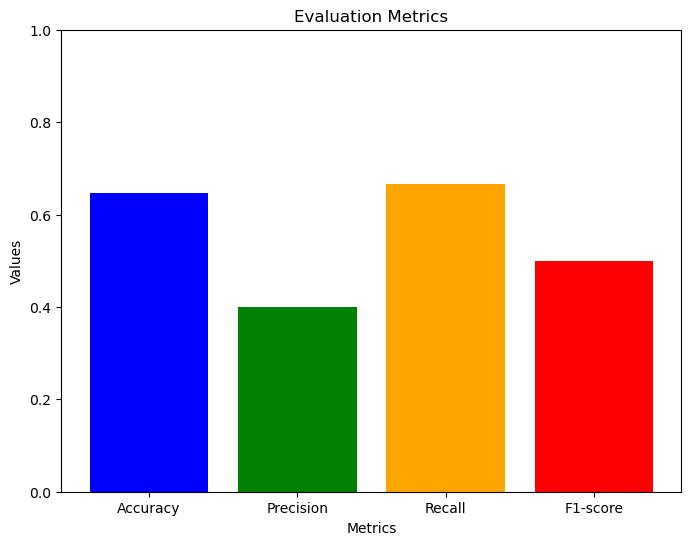

In [12]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.title('Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for better visualization
plt.show()


In [13]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)


conf_matrix

array([[16,  9],
       [ 3,  6]], dtype=int64)